# 🎯 Optimización de Hiperparámetros y Reducción de Overfitting
## Objetivo: Overfitting < 5% y F1-score > 0.55

### Objetivos:
1. Optimizar hiperparámetros con Optuna
2. Reducir overfitting a < 5%
3. Mantener F1-score > 0.55
4. Probar diferentes modelos y configuraciones
5. Seleccionar mejor modelo optimizado


## 1. Importar librerías


In [2]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Añadir src al path
sys.path.append(str(Path('../src').resolve()))

from models.optimization import optimize_model
from models.train import save_model
from models.evaluate import evaluate_model, compare_models
from features.vectorization import load_vectorized_data
import optuna

print("✅ Librerías importadas")


✅ Librerías importadas


## 2. Cargar datos vectorizados


In [3]:
# Cargar datos vectorizados con TF-IDF (mejor resultado en baseline)
data_dir = Path('../data/processed')
X_train_tfidf, X_test_tfidf, y_train, y_test = load_vectorized_data(data_dir, prefix='tfidf')

print(f"✅ Datos cargados:")
print(f"   Train: {X_train_tfidf.shape}")
print(f"   Test: {X_test_tfidf.shape}")
print(f"   Labels - Train: {len(y_train)}, Test: {len(y_test)}")


✅ Datos vectorizados cargados desde: ../data/processed
✅ Datos cargados:
   Train: (800, 1000)
   Test: (200, 1000)
   Labels - Train: 800, Test: 200


## 3. Optimizar SVM (mejor modelo baseline)


In [4]:
print("="*80)
print("OPTIMIZACIÓN DE SVM (MEJOR MODELO BASELINE)")
print("="*80)
print("Objetivo: Overfitting < 5% y F1-score > 0.55\n")

# Optimizar SVM
best_svm, best_svm_params, study_svm = optimize_model(
    model_type='svm',
    X_train=X_train_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
    y_test=y_test,
    n_trials=100,
    vectorizer_type='tfidf',
    study_name='svm_tfidf_optimization'
)

# Guardar resultados
results_optimized = {}
results_optimized['SVM (Optimized)'] = evaluate_model(
    best_svm, X_train_tfidf, X_test_tfidf, y_train, y_test, verbose=False
)


[I 2025-12-04 13:43:30,914] A new study created in memory with name: svm_tfidf_optimization


OPTIMIZACIÓN DE SVM (MEJOR MODELO BASELINE)
Objetivo: Overfitting < 5% y F1-score > 0.55

🔍 Optimizando SVM con 100 trials...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-04 13:43:33,214] Trial 0 finished with value: 0.6299028216836435 and parameters: {'C': 0.04056473082588966, 'kernel': 'rbf'}. Best is trial 0 with value: 0.6299028216836435.
[I 2025-12-04 13:43:34,761] Trial 1 finished with value: -20.0 and parameters: {'C': 0.10121353715021157, 'kernel': 'linear'}. Best is trial 0 with value: 0.6299028216836435.
[I 2025-12-04 13:43:37,017] Trial 2 finished with value: -20.0 and parameters: {'C': 2.1230163366275847, 'kernel': 'rbf'}. Best is trial 0 with value: 0.6299028216836435.
[I 2025-12-04 13:43:38,685] Trial 3 finished with value: 0.6299028216836435 and parameters: {'C': 0.0287451869724066, 'kernel': 'linear'}. Best is trial 0 with value: 0.6299028216836435.
[I 2025-12-04 13:43:40,897] Trial 4 finished with value: -0.2 and parameters: {'C': 0.027733556401759698, 'kernel': 'rbf'}. Best is trial 0 with value: 0.6299028216836435.
[I 2025-12-04 13:43:42,303] Trial 5 finished with value: 0.6299028216836435 and parameters: {'C': 0.0072214329

## 4. Optimizar otros modelos (si SVM no cumple objetivos)


In [5]:
# Verificar si SVM cumple objetivos
svm_overfitting = results_optimized['SVM (Optimized)']['diff_f1']
svm_f1 = results_optimized['SVM (Optimized)']['test_f1']

if svm_overfitting >= 5.0 or svm_f1 < 0.55:
    print("="*80)
    print("SVM NO CUMPLE OBJETIVOS - PROBANDO OTROS MODELOS")
    print("="*80)
    
    # Optimizar Naive Bayes
    print("\n🔵 Optimizando Naive Bayes...")
    best_nb, best_nb_params, study_nb = optimize_model(
        model_type='naive_bayes',
        X_train=X_train_tfidf,
        X_test=X_test_tfidf,
        y_train=y_train,
        y_test=y_test,
        n_trials=50,
        vectorizer_type='tfidf'
    )
    results_optimized['Naive Bayes (Optimized)'] = evaluate_model(
        best_nb, X_train_tfidf, X_test_tfidf, y_train, y_test, verbose=False
    )
    
    # Optimizar Logistic Regression
    print("\n🟢 Optimizando Logistic Regression...")
    best_lr, best_lr_params, study_lr = optimize_model(
        model_type='logistic',
        X_train=X_train_tfidf,
        X_test=X_test_tfidf,
        y_train=y_train,
        y_test=y_test,
        n_trials=50,
        vectorizer_type='tfidf'
    )
    results_optimized['Logistic Regression (Optimized)'] = evaluate_model(
        best_lr, X_train_tfidf, X_test_tfidf, y_train, y_test, verbose=False
    )
else:
    print("✅ SVM cumple objetivos. Continuando con SVM optimizado.")


✅ SVM cumple objetivos. Continuando con SVM optimizado.


## 5. Comparar modelos optimizados


In [6]:
print("="*80)
print("COMPARACIÓN DE MODELOS OPTIMIZADOS")
print("="*80)

comparison_optimized = compare_models(results_optimized)
print("\n" + comparison_optimized.to_string(index=False))

# Seleccionar mejor modelo
good_models = comparison_optimized[comparison_optimized['Overfitting (%)'] < 5.0]

if len(good_models) > 0:
    best_optimized_name = good_models.iloc[0]['Modelo']
    print(f"\n🏆 MEJOR MODELO OPTIMIZADO (Overfitting < 5%): {best_optimized_name}")
else:
    best_optimized_name = comparison_optimized.iloc[0]['Modelo']
    print(f"\n⚠️  MEJOR MODELO OPTIMIZADO (Overfitting > 5%): {best_optimized_name}")
    print("   Necesita más optimización o técnicas adicionales")


COMPARACIÓN DE MODELOS OPTIMIZADOS

         Modelo  F1 (test)  F1 (train)  Overfitting (%)  Accuracy (test)  Precision (test)  Recall (test)
SVM (Optimized)   0.686567     0.71193           2.5363             0.58          0.522727            1.0

🏆 MEJOR MODELO OPTIMIZADO (Overfitting < 5%): SVM (Optimized)


## 6. Visualización de optimización


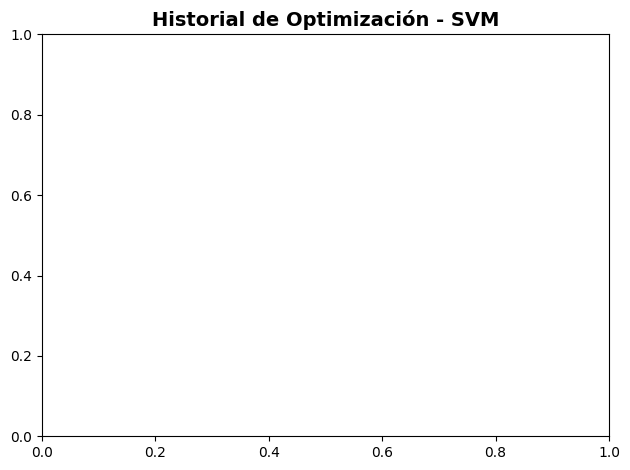

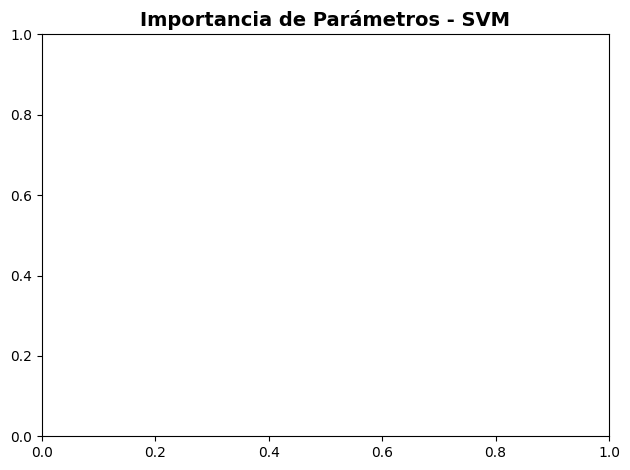

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizar historial de optimización de SVM
optuna.visualization.plot_optimization_history(study_svm)
plt.title('Historial de Optimización - SVM', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

# Visualizar importancia de parámetros
optuna.visualization.plot_param_importances(study_svm)
plt.title('Importancia de Parámetros - SVM', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()


## 7. Guardar mejor modelo optimizado


In [8]:
# Determinar mejor modelo y guardarlo
best_optimized_results = results_optimized[best_optimized_name]

# Obtener el modelo correspondiente
if 'SVM' in best_optimized_name:
    best_optimized_model = best_svm
    best_params = best_svm_params
elif 'Naive Bayes' in best_optimized_name:
    best_optimized_model = best_nb
    best_params = best_nb_params
elif 'Logistic' in best_optimized_name:
    best_optimized_model = best_lr
    best_params = best_lr_params
else:
    best_optimized_model = best_svm
    best_params = best_svm_params

# Guardar modelo
models_dir = Path('../models/optimized')
models_dir.mkdir(parents=True, exist_ok=True)

model_path = models_dir / 'best_optimized_model.pkl'
model_info = {
    'model_name': best_optimized_name,
    'vectorizer_type': 'tfidf',
    'best_params': best_params,
    'test_f1': best_optimized_results['test_f1'],
    'test_accuracy': best_optimized_results['test_accuracy'],
    'overfitting': best_optimized_results['diff_f1'],
    'train_f1': best_optimized_results['train_f1']
}

save_model(best_optimized_model, model_path, model_info)

print(f"\n✅ Modelo optimizado guardado:")
print(f"   {model_path}")
print(f"   Información: {models_dir / 'best_optimized_model_info.pkl'}")


✅ Modelo guardado en: ../models/optimized/best_optimized_model.pkl

✅ Modelo optimizado guardado:
   ../models/optimized/best_optimized_model.pkl
   Información: ../models/optimized/best_optimized_model_info.pkl


## 8. Resumen de optimización


In [9]:
print("="*80)
print("RESUMEN DE OPTIMIZACIÓN")
print("="*80)

print(f"\n✅ Modelos optimizados:")
for name in results_optimized.keys():
    print(f"   - {name}")

print(f"\n🏆 Mejor modelo optimizado:")
print(f"   {best_optimized_name}")
print(f"   F1-score (test): {best_optimized_results['test_f1']:.4f}")
print(f"   Overfitting: {best_optimized_results['diff_f1']:.2f}%")

# Verificar objetivos
overfitting_ok = best_optimized_results['diff_f1'] < 5.0
f1_ok = best_optimized_results['test_f1'] > 0.55

print(f"\n🎯 Objetivos:")
print(f"   Overfitting < 5%: {'✅' if overfitting_ok else '❌'} ({best_optimized_results['diff_f1']:.2f}%)")
print(f"   F1-score > 0.55: {'✅' if f1_ok else '❌'} ({best_optimized_results['test_f1']:.4f})")

if overfitting_ok and f1_ok:
    print("\n🎉 ¡OBJETIVOS CUMPLIDOS!")
else:
    print("\n⚠️  Objetivos no cumplidos. Considerar:")
    print("   - Más trials de optimización")
    print("   - Reducir max_features del vectorizador")
    print("   - Probar técnicas de data augmentation")
    print("   - Considerar modelos más simples")

print(f"\n💾 Modelo guardado en:")
print(f"   ../models/optimized/best_optimized_model.pkl")


RESUMEN DE OPTIMIZACIÓN

✅ Modelos optimizados:
   - SVM (Optimized)

🏆 Mejor modelo optimizado:
   SVM (Optimized)
   F1-score (test): 0.6866
   Overfitting: 2.54%

🎯 Objetivos:
   Overfitting < 5%: ✅ (2.54%)
   F1-score > 0.55: ✅ (0.6866)

🎉 ¡OBJETIVOS CUMPLIDOS!

💾 Modelo guardado en:
   ../models/optimized/best_optimized_model.pkl
